Goal: Deproject disks by rotating them about x and z axes, using info about inclination and position angles, so that they are all circular

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from scipy.interpolate import interp2d

Text(0.5, 1.0, 'HD 163296')

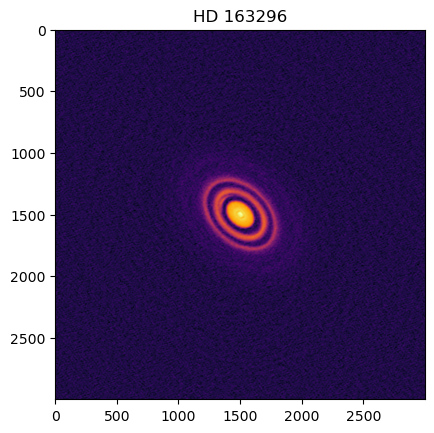

In [48]:
#########           Edit this if necessary       ################
filepath = 'HD163296.png'
#####################################################
img = imread(filepath)
img = (img - np.min(img)) / (np.max(img) - np.min(img))         # Normalize
img = np.arcsinh(img/0.2) / np.arcsinh(1/0.2)                   # arcsinh stretch
plt.imshow(img, cmap='inferno')
plt.title('HD 163296')

### Coordinate system transformation
Inclination and position angles from Table 2 in DSHARP II (Huang et al.): https://iopscience.iop.org/article/10.3847/2041-8213/aaf740/pdf

In [49]:
incl = -46.7 #inclination angle in deg
incl = np.radians(incl)
PA = -133.33
PA = np.radians(PA)
R_x = np.array([[1, 0, 0],
                [0, np.cos(incl), -1*np.sin(incl)],
                [0, np.sin(incl), np.cos(incl)]])
R_y = np.array([[np.cos(PA), 0, np.sin(PA)],
                [0, 1, 0],
                [-1*np.sin(PA), 0, np.cos(PA)]])
R_z = np.array([[np.cos(PA), -1*np.sin(PA), 0],
                [np.sin(PA), np.cos(PA), 0],
                [0, 0, 1]])
xnew = []
ynew = []
znew = []
# For each image coordinate in the 3000x3000 grid:
# translate so that disk is centered on the origin
# Rotate about y axis by PA
# Rotate about x axis by incl
for x, y in zip(range(len(img[0])), range(len(img[1]))):
    x = x-1500
    y = y-1500
    pix = [x,y,0]
    pix = R_z@pix
    pix = R_x@pix

    xnew.append(pix[0])
    ynew.append(pix[1])
    #znew.append(pix[2])

### Interpolation

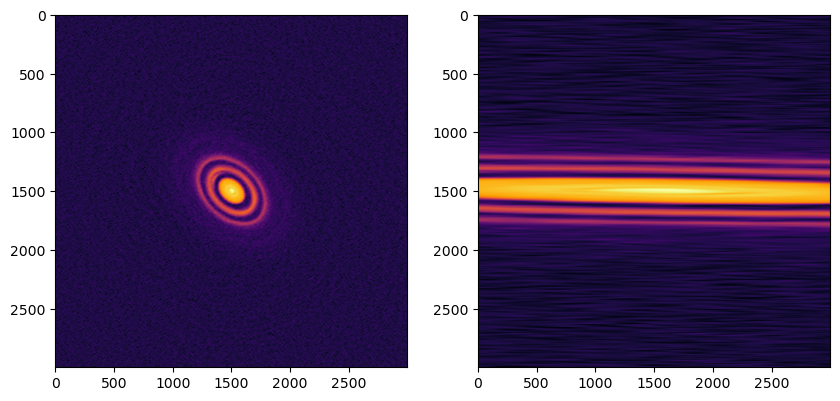

In [50]:
# attempt to interpolate the intensity values at image coordinates to the new coordinate system defined by (xnew, ynew)
xdense = np.linspace(-1500, 1500, 3000)
ydense = np.linspace(-1500, 1500, 3000)

interpolator = interp2d(xdense,ydense, img)
newimg = interpolator(xnew, ynew)

plt.figure(figsize=(10,10))
arrs = [img, newimg]
for i in range(2):
    plt.subplot(1,2,i+1)   
    plt.imshow(arrs[i], cmap='inferno')

plt.show()

### Minimum working example:
Project a circle to an ellipse using the same values of incl and PA as for HD 163296

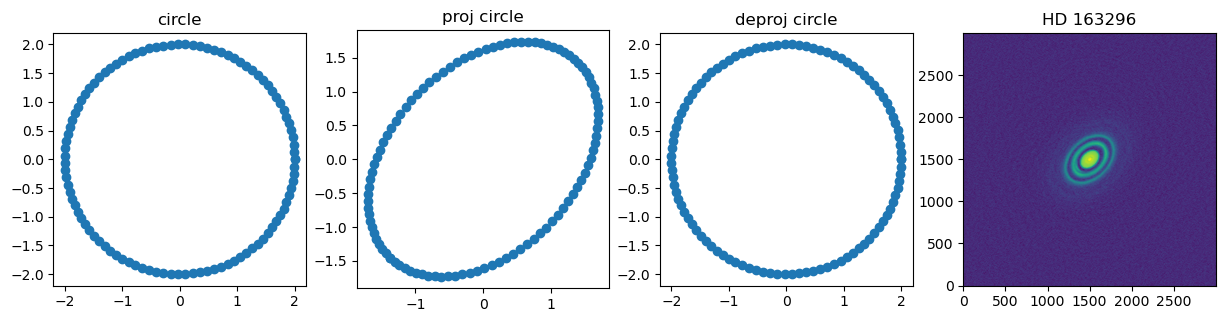

In [51]:
theta = np.linspace(0, 2*np.pi, 100)
R = 2
x = R*np.cos(theta)
y = R*np.sin(theta)

xnew = []
ynew = []

for xi, yi in zip(x, y):
    point = [xi, yi, 0]
    point = R_x@point
    point = R_z@point
    xnew.append(point[0])
    ynew.append(point[1])
    znew.append(point[2])
    
xnew2 = []
ynew2 = []
R_xinv = np.array([[1, 0, 0],
                   [0, np.cos(incl), np.sin(incl)],
                   [0, -1*np.sin(incl), np.cos(incl)]])

R_zinv = np.array([[np.cos(PA), np.sin(PA), 0],
                   [-1*np.sin(PA), np.cos(PA), 0],
                   [0, 0, 1]])
for xi, yi, zi in zip(xnew, ynew, znew):
    point = [xi, yi, zi]
    point = R_zinv@point
    point = R_xinv@point
    xnew2.append(point[0])
    ynew2.append(point[1])
    
figure, axes = plt.subplots(1,4)
figure.set_figwidth(15)
axes[0].scatter(x, y)
axes[0].set_aspect(1)
axes[0].set_title('circle')

axes[1].scatter(xnew, ynew)
axes[1].set_aspect(1)
axes[1].set_title('proj circle')

axes[2].scatter(xnew2, ynew2)
axes[2].set_aspect(1)
axes[2].set_title('deproj circle')

axes[3].imshow(img, origin='lower')
axes[3].set_title('HD 163296')
plt.show()

### try using warpPerspective instead of an interpolator


In [52]:
from cv2 import warpPerspective

In [53]:
# new = warpPerspective(input_image, M, (maxwidth, maxheight))
# M = transformation matrix
incl = 46.7
incl = np.radians(incl)
PA = 133.33
PA = np.radians(PA)
R_xinv = np.array([[1, 0, 0],
                   [0, np.cos(incl), np.sin(incl)],
                   [0, -1*np.sin(incl), np.cos(incl)]])
R_zinv = np.array([[np.cos(PA), np.sin(PA), 0],
                   [-1*np.sin(PA), np.cos(PA), 0],
                   [0, 0, 1]])

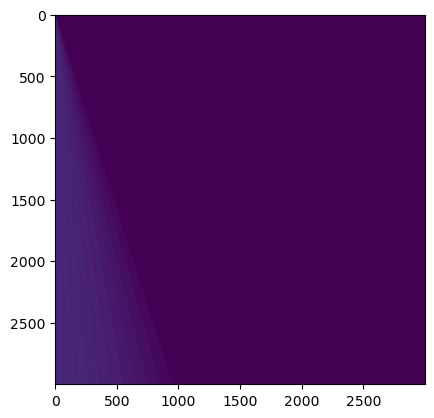

In [54]:
M = R_x@R_zinv
new = warpPerspective(img, M, (3000,3000))
plt.imshow(new)

### various links
https://www.mathworks.com/matlabcentral/answers/1898145-how-to-rotate-a-2d-array-2d-image-in-3d-space-around-the-x-axis <br>
https://towardsdatascience.com/how-to-transform-a-2d-image-into-a-3d-space-5fc2306e3d36 <br>
https://medium.com/vitrox-publication/rotation-of-voxels-in-3d-space-using-python-c3b2fc0afda1 <br>